In [20]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import gm
%matplotlib inline

## Set the parameters required for computing the GM spectrum
How do we compute those values from typical profiles? Should we fit an exponential function?

In [21]:
OMEGA_EARTH = 7.2921e-5
lat = -23
# Coriolis frequency
f = 2 * OMEGA_EARTH * np.sin(lat)
# buoyancy frequency (corresponding to 1000 m depth)
N = 2.4e-3
# surface-extrapolated buoyancy frequency
N0 = 5.2e-3
# e-folding scale of N(z)
b = 1.3e3

## Initialize wavenumber and frequency coordinates using Xarray

Horizontal wavenumbers are defined in $m^{-1}$:

In [22]:
kh = xr.IndexVariable('kh', 2 * np.pi * np.logspace(-6, -2, 401),
                     attrs={'long_name': 'Horizontal wavelength', 'units' :'rad.m-1'})
print(kh)

<xarray.IndexVariable 'kh' (kh: 401)>
array([6.283185e-06, 6.429539e-06, 6.579303e-06, ..., 6.000395e-02,
       6.140163e-02, 6.283185e-02])
Attributes:
    long_name:  Horizontal wavelength
    units:      rad.m-1


Frequencies are defined in $s^{-1}$ and taken between the Coriolis frequency $f$ an the buoyancy frequency $N$:

In [23]:
omega = xr.IndexVariable('omega', np.logspace(np.log10(1.01 * f), np.log10(N), 401),
                         attrs={'name': 'Frequency', 'units' :'rad.s-1'})
print(omega)

<xarray.IndexVariable 'omega' (omega: 401)>
array([0.000125, 0.000126, 0.000127, ..., 0.002365, 0.002382, 0.0024  ])
Attributes:
    name:     Frequency
    units:    rad.s-1


A hundred vertical modes are used to compute the spectrum:

In [24]:
j = xr.IndexVariable('mode', np.arange(1, 100),
                     attrs={'name': 'Vertical mode'})
print(j)

<xarray.IndexVariable 'mode' (mode: 99)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99])
Attributes:
    name:     Vertical mode


## Compute the two-dimensional GM spectra

The frequency spectra of Kinetic Energy $KE(\omega, j)$, Potential Energy $PE(\omega, j)$ and Sea Surface Height $\eta(\omega, j)$ are computed for each vertical mode:

In [25]:
KE_omega_j = gm.ke_omega_j(omega, j, f, N, N0, b)
PE_omega_j = gm.pe_omega_j(omega, j, f, N, N0, b)
eta_omega_j = gm.eta_omega_j(omega, j, f, N, N0, b)
KE_omega = KE_omega_j.sum('mode')
PE_omega = PE_omega_j.sum('mode')
eta_omega = eta_omega_j.sum('mode')

The wavenumber spectra of Kinetic Energy $KE(k, j)$, Potential Energy $PE(k, j)$ and Sea Surface Height $\eta(k, j)$ are also computed for each vertical mode:

In [26]:
# wavenumber spectra (KE and PE)
KE_kh_j = gm.ke_k_j(kh, j, f, N, N0, b)
PE_kh_j = gm.pe_k_j(kh, j, f, N, N0, b)
eta_kh_j = gm.eta_k_j(kh, j, f, N, N0, b)
KE_kh = KE_kh_j.sum('mode')
PE_kh = PE_kh_j.sum('mode')
eta_kh = eta_kh_j.sum('mode')

\begin{equation}
  S_{1d} = \frac{2}{\pi} \int_k^\infty \frac{S_{2d}}{\sqrt{{k_h}^2-k^2}} dk_h
\end{equation}

In [27]:
k = xr.IndexVariable('k', 2 * np.pi * np.logspace(-6, -2, 401),
                      attrs={'long_name': 'Wavelength', 'units' :'rad.m-1'}) 
KE_k = gm.compute_1d_spectrum(k, KE_kh)
PE_k = gm.compute_1d_spectrum(k, PE_kh)
eta_k = gm.compute_1d_spectrum(k, eta_kh)

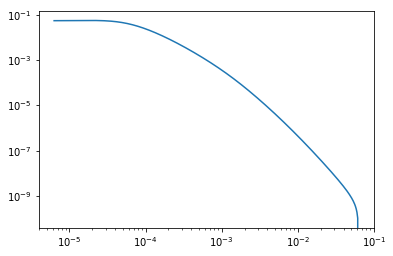

In [28]:
plt.loglog(k, eta_k)

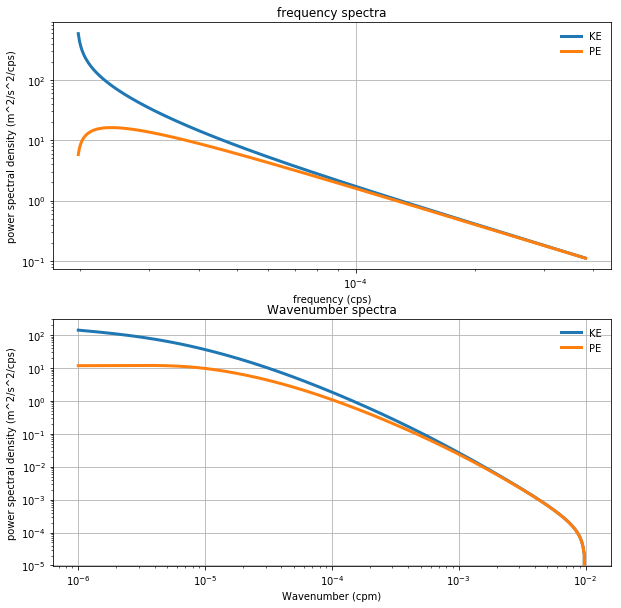

In [29]:
fig = plt.figure(figsize=(10, 10))
# plot frequency spectra
ax = plt.subplot(211)
ax.loglog(omega / (2 * np.pi), 2 * np.pi * KE_omega, 
          label='KE', lw=3)
ax.loglog(omega / (2 * np.pi), 
          2 * np.pi * PE_omega_j.sum('mode'), 
          label='PE', lw=3)
ax.legend(frameon=False)
ax.set_title('frequency spectra')
ax.set_xlabel('frequency (cps)')
ax.set_ylabel('power spectral density (m^2/s^2/cps)')
ax.grid()
# plot frequency spectra
ax = plt.subplot(212)
ax.loglog(k / (2 * np.pi), 
          2 * np.pi * KE_k, 
          label='KE', lw=3)
ax.loglog(k / (2 * np.pi), 
          2 * np.pi * PE_k, 
          label='PE', lw=3)
ax.legend(frameon=False)
ax.set_title('Wavenumber spectra')
ax.set_xlabel('Wavenumber (cpm)')
ax.set_ylabel('power spectral density (m^2/s^2/cps)')
ax.grid()

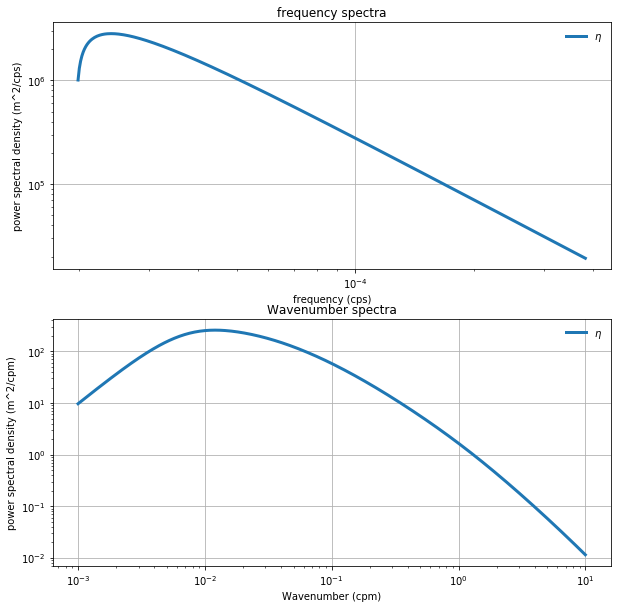

In [30]:
fig = plt.figure(figsize=(10, 10))
# plot frequency spectra
ax = plt.subplot(211)
ax.loglog(omega / (2 * np.pi), 
          2 * np.pi * PE_omega / N ** 2, 
          label=r'$\eta$', lw=3)
ax.legend(frameon=False)
ax.set_title('frequency spectra')
ax.set_xlabel('frequency (cps)')
ax.set_ylabel('power spectral density (m^2/cps)')
ax.grid()
# plot frequency spectra
ax = plt.subplot(212)
ax.loglog(k / (2 * np.pi) * 1e3 , 
          1e-3 * 2 * np.pi * PE_kh / N0 ** 2, 
          label=r'$\eta$', lw=3)
ax.legend(frameon=False)
ax.set_title('Wavenumber spectra')
ax.set_xlabel('Wavenumber (cpm)')
ax.set_ylabel('power spectral density (m^2/cpm)')
ax.grid()

## Build the GM velocity structure functions from the Kinetic Energy spectrum

The analytical link between structure functions and spectra is used to build the corresponding GM structure function:
\begin{equation}
D_{UU}(r) = 2 \int_0^\infty E(k)\left[1-J_0(kr)\right]dk.
\end{equation}

In [31]:
r = xr.IndexVariable('r', np.logspace(2, 6, 401))

#### Compute the corresponding integral

In [32]:
from scipy.special import j0
dk = xr.DataArray(k).diff('k') # Differentiate the wavenumber vector
Duu = 2 * (KE_k * (1 - j0(k * r)) * dk).sum('k')
print(Duu)

<xarray.DataArray (r: 401)>
array([2.121649e-05, 2.191241e-05, 2.262497e-05, ..., 3.005706e-03,
       3.007109e-03, 3.008703e-03])
Dimensions without coordinates: r


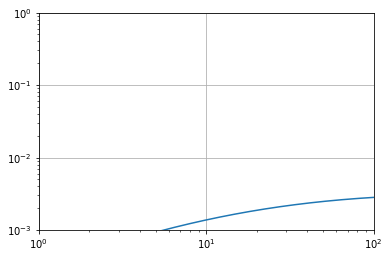

In [33]:
fig, ax = plt.subplots()
plt.loglog(r * 1e-3, Duu)
plt.xlim([1, 100])
plt.ylim([1e-3, 1])
plt.grid()

## GM spectrum for Sea Surface Height

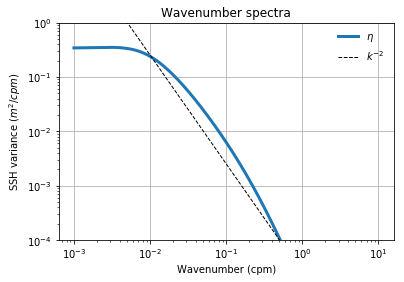

In [44]:
ax = plt.subplot(111)
ax.loglog(1e3 * k / (2 * np.pi), 
          2 * np.pi * eta_k, 
          label=r'$\eta$', lw=3)
ax.loglog(1e3 * k / (2 * np.pi), 
          1e-9 * k ** (-2), 
          label=r'$k^{-2}$', lw=1, ls='--', color='black')
ax.legend(frameon=False)
ax.set_title('Wavenumber spectra')
ax.set_xlabel('Wavenumber (cpm)')
ax.set_ylabel('SSH variance $(m^2/cpm)$')
ax.set_ylim([1e-4, 1])
ax.grid()

In [37]:
# Putting everything into one function
def compute_GM_structure_function(lat, N, N0, b):
    OMEGA_EARTH = 7.2921e-5
    # Compute Coriolis frequency
    f = 2 * OMEGA_EARTH * np.sin(np.pi / 180. * abs(lat))
    # Generate horizontal wavenumbers and modes 
    kh = gm.generate_kh()
    j = gm.generate_modes()
    # Compute the wavenumber spectrum 
    KE_kh_j = gm.ke_k_j(kh, j, f, N, N0, b)
    KE_kh = KE_kh_j.sum('mode')
    # Convert the spectrum into structure functions
    r = xr.IndexVariable('r', np.logspace(2, 6, 401))
    Duu = gm.spectrum_to_structure_function(KE_kh, r, dim='kh')
    Duu  = Duu.assign_coords(r=r)
    return Duu

In [53]:
# Putting everything into one function
def compute_GM_structure_function_PE(lat, N, N0, b):
    OMEGA_EARTH = 7.2921e-5
    # Compute Coriolis frequency
    f = 2 * OMEGA_EARTH * np.sin(np.pi / 180. * abs(lat))
    # Generate horizontal wavenumbers and modes 
    kh = gm.generate_kh()
    j = gm.generate_modes()
    # Compute the wavenumber spectrum 
    PE_kh_j = gm.pe_k_j(kh, j, f, N, N0, b)
    PE_kh = PE_kh_j.sum('mode')
    # Convert the spectrum into structure functions
    r = xr.IndexVariable('r', np.logspace(2, 6, 401))
    Drhorho = N ** 2 / 9.81 ** 2 * gm.spectrum_to_structure_function(PE_kh, r, dim='kh')
    Drhorho  = Drhorho.assign_coords(r=r)
    return Drhorho

In [39]:
Duu = compute_GM_structure_function(-16, 0.010452, 0.011127550241290645, 792)

In [54]:
Drhorho = compute_GM_structure_function_PE(-16, 0.010452, 0.011127550241290645, 792)

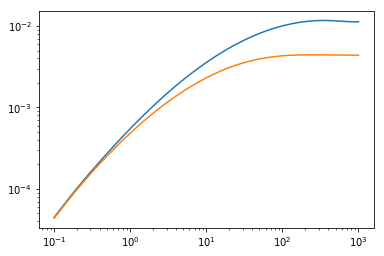

In [44]:
plt.loglog(1e-3 * Duu['r'], Duu)
plt.loglog(1e-3 * Drhorho['r'], Drhorho)

(1e-10, 1e-06)

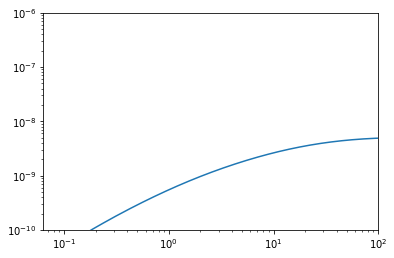

In [55]:
plt.loglog(1e-3 * Drhorho['r'], Drhorho)
plt.xlim([0, 100])
plt.ylim([1e-10, 1e-6])